In [13]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from functions import get_zone, load_360_data, get_progressive_actions, zone_polygon, plot_team_zone_shares, calc_width
import seaborn as sns

### Features to use

Main tactical features to use:
- Width offensivly ✅
Average distance from center-line (goal-to-goal) where progressive actions end. 
- Directness ✅
Relationship of progressive actions to non progressive actions
- Tempo
Velocity of ball, how fast do actions happen?
- Pass length

- Restförsvar ?
- Fasta situationer ?
- Press, triggers (defensiva aktioner i offensiv planhalva) (tid för bollvinst)
- Höjd på backlinje
- Antal progressiva passningar
- Bollhastighet
- Final third entries

### Game State:
- Which zone are we in?
- Distance to goal?
- Angle to goal?
- Opponents near?
- How many opponants near?
- Score?
-  Red cards?

### Tactics: 


In [14]:
actions=("Pass", "Carry", "Dribble")
action_types_exclude = ["Throw-in", "Corner", "Free Kick", "Kick-off", "Goal Kick"]
df = load_360_data(actions, three_sixty_only=False)



#is_dead_ball_action = df["pass_type"].isin(action_types_exclude)


actions = get_progressive_actions(df=df)
prog_passes = actions[actions["is_progressive"] == True]



Loading events: 100%|██████████| 3464/3464 [02:48<00:00, 20.52it/s]


In [15]:
def calc_directness(df, match=True):
    """
    Directness = share of actions that are progressive
               = (# progressive) / (# total)

    Requires:
      - match_id
      - team_id
      - is_progressive (bool)
    """
    df_whole = df.copy()

    # enforce integer IDs early
    for c in ["match_id", "team_id"]:
        if c in df_whole.columns:
            df_whole[c] = df_whole[c].astype("Int64")

    group_cols = ["match_id", "team_id"] if match else ["team_id"]

    directness = (
        df_whole.groupby(group_cols)
        .agg(
            n_total=("is_progressive", "size"),
            n_prog=("is_progressive", "sum"),
        )
        .reset_index()
    )

    directness["directness"] = directness["n_prog"] / directness["n_total"]

    return directness

In [18]:


def plot_two_matches(df, a, b):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    pitch = Pitch(pitch_type="statsbomb", line_zorder=2)

    for ax, row, title in zip(
        axes,
        [a, b],
        ["Widest match", "Most central match"]
    ):
        pitch.draw(ax=ax)

        subset = df[
            (df["match_id"] == row["match_id"]) &
            (df["team_id"] == row["team_id"]) 
            #&(df["is_progressive"])
        ]

        passes  = subset[subset["type"] == "Pass"]
        carries = subset[subset["type"] == "Carry"]

        # --- passes (blue) ---
        pitch.lines(
            passes["x"], passes["y"],
            passes["endx"], passes["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:blue", label="Pass"
        )
        pitch.scatter(
            passes["x"], passes["y"],
            ax=ax, s=20, color="tab:blue"
        )

        # --- carries (orange) ---
        pitch.lines(
            carries["x"], carries["y"],
            carries["endx"], carries["endy"],
            ax=ax,
            lw=2, alpha=0.7, color="tab:orange", label="Carry"
        )
        pitch.scatter(
            carries["x"], carries["y"],
            ax=ax, s=20, color="tab:orange"
        )

        ax.set_title(
        f"{title}\nprogressive actions / all actions = {row['directness']:.2f}"
)
        ax.legend(loc="upper left")

    plt.show()
assert "is_progressive" in prog_passes.columns
# 1) compute "directness" = progressive share per match/team
directness_mt = calc_directness(actions, match=False)  # returns match_id, team_id, n_total, n_prog, directness

# (optional) drop groups with very few actions so you don't pick a weird tiny-sample match
directness_mt = directness_mt[directness_mt["n_total"] >= 30].copy()

# 2) pick most / least direct
most_direct  = directness_mt.loc[directness_mt["directness"].idxmax()]
least_direct = directness_mt.loc[directness_mt["directness"].idxmin()]

print("Most direct:\n", most_direct, "\n")
print("Least direct:\n", least_direct, "\n")



Most direct:
 team_id          872.0
n_total        11316.0
n_prog          5470.0
directness    0.483386
Name: 187, dtype: Float64 

Least direct:
 team_id          575.0
n_total          541.0
n_prog           119.0
directness    0.219963
Name: 124, dtype: Float64 



KeyError: 'match_id'

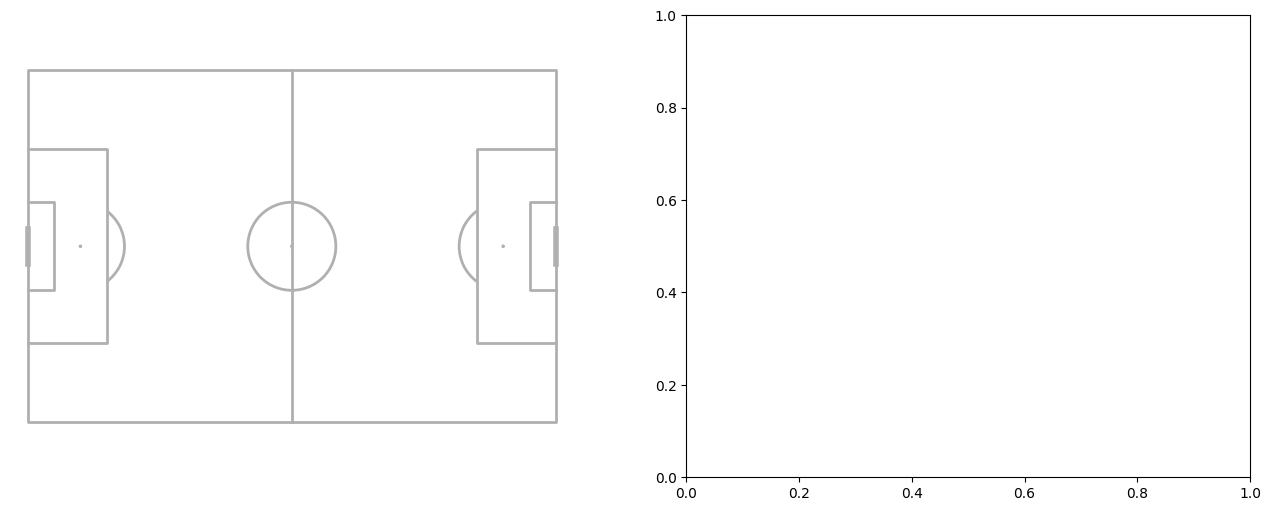

In [19]:
plot_two_matches(actions, most_direct, least_direct)
